In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
mpl.rcParams['hatch.linewidth'] = 0.25

In [29]:
gcm_files = {
    2: "file_path_for_gcm2.csv",
    3: "file_path_for_gcm3.csv",
    4: "file_path_for_gcm4.csv",
    5: "file_path_for_gcm5.csv",
    6: "file_path_for_gcm6.csv",
    7: "file_path_for_gcm7.csv",
    8: "file_path_for_gcm8.csv",
    9: "file_path_for_gcm9.csv",
    10: "file_path_for_gcm10.csv",
    11: "file_path_for_gcm11.csv",
    12: "file_path_for_gcm12.csv",
    13: "file_path_for_gcm13.csv",
    14: "file_path_for_gcm14.csv",
    15: "file_path_for_gcm15.csv",
    16: "file_path_for_gcm16.csv",
    17: "file_path_for_full_gcm.csv"  
}

gcm_dfs = []

for gcm_number, file_path in gcm_files.items():
    df = pd.read_csv(file_path)
    df['number_of_gcm'] = gcm_number
    gcm_dfs.append(df)

gcm = pd.concat(gcm_dfs, ignore_index=True)
gcm["gcm"] = gcm["gcm"] * 100

In [34]:
grouped = gcm.groupby('year')
year_dict = {year: data for year, data in grouped}

In [35]:
for key in year_dict: 
    year_dict[key] = year_dict[key][["gcm", "code", "number_of_gcm"]]

In [36]:
avg_dict = {}

for key in year_dict:
    avg_dict[key] = year_dict[key].groupby(["code", "number_of_gcm"])["gcm"].mean().reset_index()

In [38]:
gcm_avg = gcm.groupby(["code", "number_of_gcm"])["gcm"].mean().reset_index()

In [40]:
year_avg = gcm.groupby(["year", "number_of_gcm"])["gcm"].mean().reset_index()

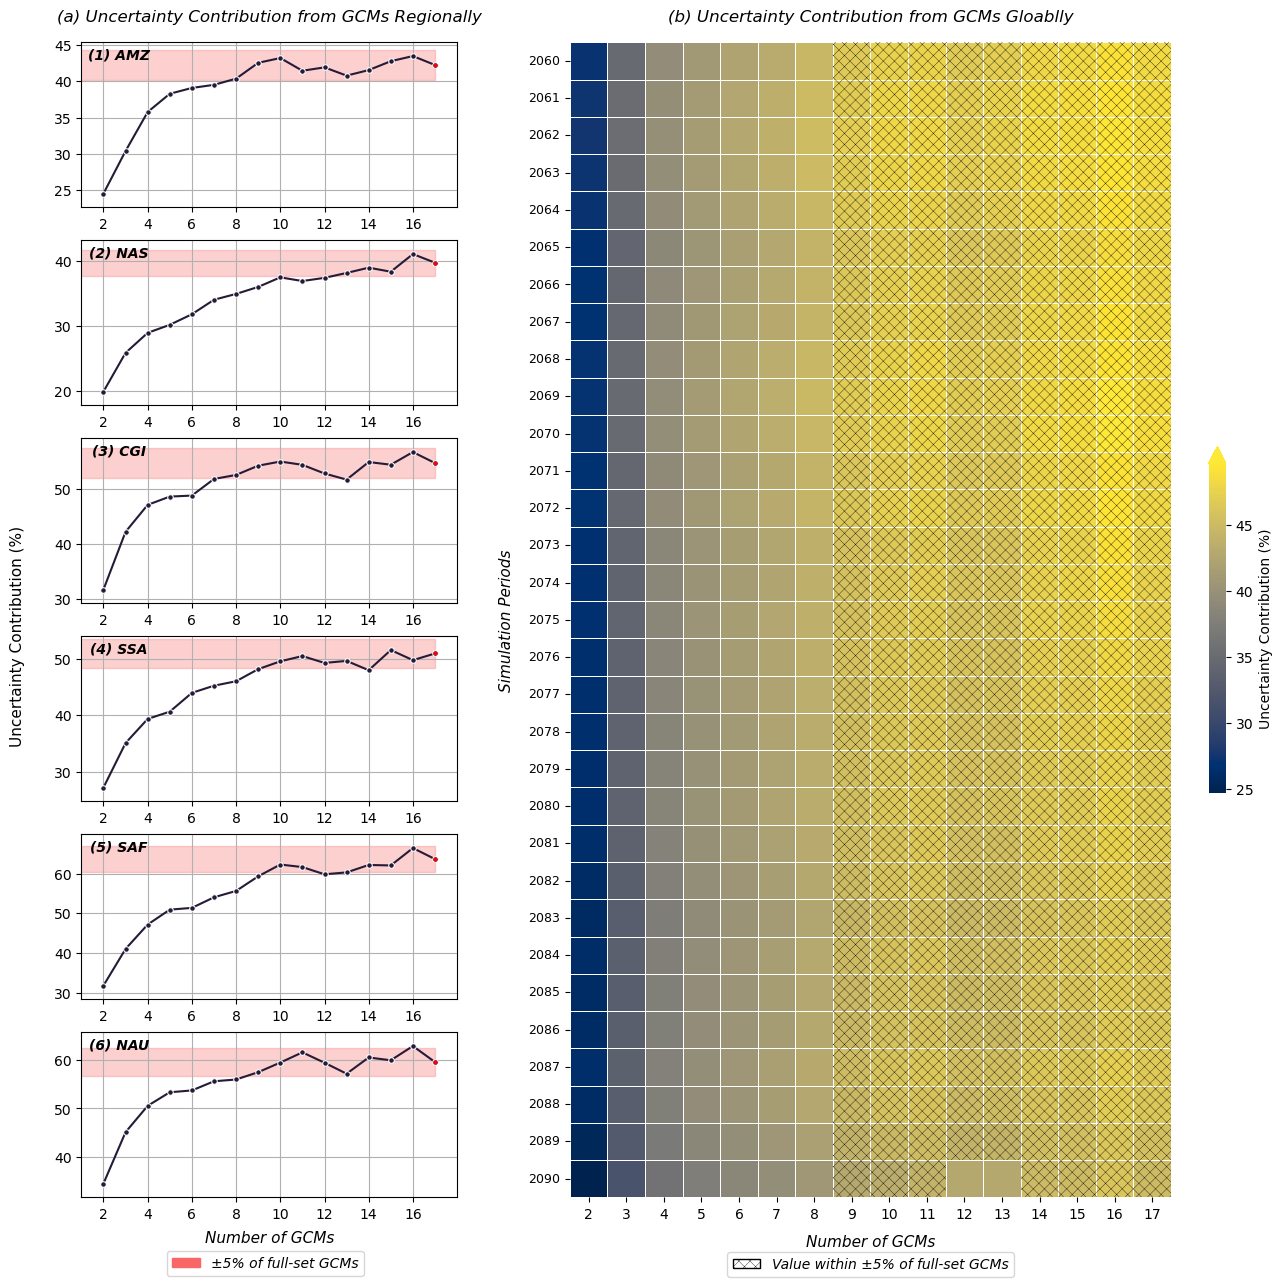

In [45]:
heatmap_data = year_avg.pivot(index='year', columns='number_of_gcm', values='gcm')

range_percent = 0.05
highlight_mask = pd.DataFrame(False, index=heatmap_data.index, columns=heatmap_data.columns)
reference_values = year_avg.loc[year_avg['number_of_gcm'] == 17].set_index('year')['gcm']

for i in heatmap_data.index:
    if i in reference_values.index:
        target_value = reference_values[i]
        range_min = target_value * (1 - range_percent)
        range_max = target_value * (1 + range_percent)
        highlight_mask.loc[i, :] = (heatmap_data.loc[i, :] >= range_min) & (heatmap_data.loc[i, :] <= range_max)

regions = ["AMZ", "NAS", "CGI", "SSA", "SAF", "NAU"]
num_regions = len(regions)
num_cols = 1
num_rows = (num_regions + num_cols - 1) // num_cols

fig = plt.figure(figsize=(16, 15))
gs = GridSpec(1, 2, width_ratios=[0.5, 1])

frame_ax = fig.add_subplot(gs[0])
frame_ax.set_visible(False)

gs2 = GridSpecFromSubplotSpec(num_rows, num_cols, subplot_spec=frame_ax)
axes = [fig.add_subplot(gs2[row, col]) for row in range(num_rows) for col in range(num_cols)]

for i, (ax, region) in enumerate(zip(axes, regions)):
    region_data = gcm_avg[gcm_avg['code'] == region]
    
    sns.lineplot(data=region_data, x='number_of_gcm', y='gcm', marker='o', ax=ax, markersize=4, color="#251B37")
    
    gcm_value_at_17 = region_data.loc[region_data['number_of_gcm'] == 17, 'gcm'].values[0]
    
    lower_bound = gcm_value_at_17 * 0.95
    upper_bound = gcm_value_at_17 * 1.05

    ax.fill_betweenx(y=[lower_bound, upper_bound], x1=0, x2=17, color='#F96666', alpha=0.3)

    highlight_data = region_data[region_data['number_of_gcm'] == 17]
    ax.scatter(highlight_data['number_of_gcm'], highlight_data['gcm'], color='red', zorder=5, s=4)
    
    ax.text(
        0.1, 0.9, 
        f"({i+1}) {region}",  
        transform=ax.transAxes,  
        ha='center',  
        fontsize=10,  
        style='italic', 
        fontweight = "bold"
    )
    
    ax.grid(True)
    
    x_min, x_max = region_data['number_of_gcm'].min(), region_data['number_of_gcm'].max()
    y_min, y_max = region_data['gcm'].min(), region_data['gcm'].max()
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - (y_max - y_min) * 0.1, y_max + (y_max - y_min) * 0.1)

    ax.set_xticks(range(int(x_min), int(x_max) + 1, 2))

    ax.set_ylabel('')
    ax.set_xlabel('')

for ax in axes[num_regions:]:
    fig.delaxes(ax)

axes[5].set_xlabel('Number of GCMs', fontsize=11, style="italic")
axes[5].xaxis.set_label_coords(0.5, -0.2) 

axes[2].set_ylabel('Uncertainty Contribution (%)', fontsize=11, labelpad=5)
axes[2].yaxis.set_label_coords(-.15, -0.2) 

legend_patch = mpatches.Patch(color='#F96666', label='±5% of full-set GCMs')
fig.legend(handles=[legend_patch], loc='lower center', fontsize=11, prop={'style': 'italic'}, bbox_to_anchor=(0.24, 0.053))
axes[0].set_title("(a) Uncertainty Contribution from GCMs Regionally", fontsize=12, style="italic", pad=15)

ax1 = fig.add_subplot(gs[1])
heatmap = sns.heatmap(
    heatmap_data,
    fmt=".2f",
    cmap="cividis",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={'label': 'Uncertainty Contribution (%)',
              'shrink': 0.3,
              'extend': 'max'},
    ax=ax1
)

for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        if highlight_mask.iloc[i, j]:
            rect = plt.Rectangle((j, i), 1, 1, fill=False, hatch='XXX', edgecolor='black', linewidth=0)
            ax1.add_patch(rect)

ax1.set_title('(b) Uncertainty Contribution from GCMs Gloablly', fontsize=12, style="italic", pad=15)
ax1.set_xlabel('Number of GCMs', fontsize=11, labelpad=10, style="italic")
ax1.set_ylabel('Simulation Periods', fontsize=11, labelpad=10, style="italic")

ax1.tick_params(axis='x', labelsize=10, rotation=0)
ax1.tick_params(axis='y', labelsize=9, rotation=0)

hatch_patch = patches.Patch(facecolor='none', edgecolor='black', hatch='XXX', 
                            label='Value within ±5% of full-set GCMs')
font_properties = FontProperties(style='italic', size = 10)
ax1.legend(handles=[hatch_patch], loc='lower right', bbox_to_anchor=(0.75, -0.075), prop=font_properties)

plt.savefig("save_path.png",  bbox_inches='tight')
plt.show()
